In [1]:
#%pip install python-louvain

#kmeans+tfidf https://jonathansoma.com/lede/algorithms-2017/classes/clustering/k-means-clustering-with-scikit-learn/
#tfidf+graph https://towardsdatascience.com/how-to-cluster-similar-sentences-using-tf-idf-and-graph-partitioning-in-python-5fb70627a4e0

In [2]:
import os, sys
import argparse
import ast

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

import advertools as adv

In [3]:
data = pd.read_csv('sectioned_data_2022.csv')
data

,Unnamed: 0,ecli,date,inhoudsindicatie,procesverloop,overwegingen,beslissing,sections
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,"['Overwegingen', '1.1 Appellant heeft op 10 me..."
1,1,ECLI:NL:CBB:2022:10,2022-01-18,\n\nMond - en klauwzeer. Medio maart 2001 is i...,Procesverloop Bij besluit van 29 maart 2001 (h...,Overwegingen Feiten en omstandigheden 1. Het C...,Beslissing Het College: verklaart het beroep g...,"['Overwegingen Feiten en omstandigheden', ' 1...."
2,2,ECLI:NL:CBB:2022:100,2022-03-08,\n\n-\tBeleidsregel tegemoetkoming ondernemers...,Procesverloop Bij besluit van 3 februari 2021 ...,Overwegingen 1. Het wettelijk kader is opgenom...,Beslissing Het College: - verklaart het beroep...,"['Overwegingen', ' 1. Het wettelijk kader is o..."
3,3,ECLI:NL:CBB:2022:101,2022-03-08,"\nWarenwet, hoger beroep, Verordening 853/2004...",Procesverloop in hoger beroep De minister heef...,Grondslag van het geschil 1.1 De rechtbank hee...,Beslissing Het College bevestigt de aangevalle...,"['Grondslag van het geschil', '1.1 De rechtban..."
4,4,ECLI:NL:CBB:2022:102,2022-03-08,\nRegeling garanties van oorsprong en certific...,Procesverloop Bij afzonderlijke besluiten van ...,Overwegingen Inleiding 1.1 Appellanten exploit...,Beslissing Het College: verklaart de beroepen ...,"['Overwegingen Inleiding', '1.1 Appellanten ex..."
...,...,...,...,...,...,...,...,...
95,95,ECLI:NL:CBB:2022:206,2022-05-03,\nISDE-subsidie voor warmtepompen. Aanvragen a...,Procesverloop Bij 32 afzonderlijke besluiten v...,Overwegingen In de periode van 12 maart 2019 t...,Beslissing Het College verklaart het beroep on...,['Overwegingen In de periode van 12 maart 2019...
96,96,ECLI:NL:CBB:2022:207,2022-05-03,\nSDE-subsidie voor co-vergistingsinstallaties...,Procesverloop Appellanten hebben beroep ingest...,Overwegingen 1.1 Verweerder heeft aan appellan...,Beslissing Het College verklaart de beroepen o...,"['Overwegingen', '1.1 Verweerder heeft aan app..."
97,97,ECLI:NL:CBB:2022:208,2022-05-03,\nVerzoek om schadevergoeding wordt afgewezen....,Procesverloop Verzoeker heeft op 4 december 20...,Overwegingen Relevante bepalingen 1.\tOp grond...,Beslissing Het College wijst het verzoek tot s...,"['Overwegingen Relevante bepalingen', ' 1.\tOp..."
98,98,ECLI:NL:CBB:2022:209,2022-05-03,\n\nFosfaatrechten – verzoek schadevergoeding\...,Procesverloop Op 29 oktober 2020 heeft verzoek...,Overwegingen Relevante bepalingen 1.1 Op grond...,Beslissing Het College: veroordeelt verweerder...,"['Overwegingen Relevante bepalingen', '1.1 Op ..."


In [4]:
data['sections'] = data['sections'].apply(ast.literal_eval)
extended_data = data.explode('sections')
extended_data

,Unnamed: 0,ecli,date,inhoudsindicatie,procesverloop,overwegingen,beslissing,sections
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,Overwegingen
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.1 Appellant heeft op 10 mei 2020 een aanvraa...
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,4.5 van de Regeling. De minister van BZK heeft...
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.2 In navolging van het e-mailbericht van 2 s...
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,"1.3 Bij het primaire besluit, dat is gehandhaa..."
...,...,...,...,...,...,...,...,...
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,"74.20.1, betekent niet dat verweerder de aanvr..."
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,7. Anders dan appellant is het College van oo...
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,71.20.2 wel passend is bij de bedrijfsomschrij...
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,8. Het College volgt verweerder in het standp...


In [5]:
import re
extended_data['clean'] = [re.findall(r'[^\W\d_]+', i.lower()) for i in extended_data['sections'].fillna('NONE')]
extended_data

,Unnamed: 0,ecli,date,inhoudsindicatie,procesverloop,overwegingen,beslissing,sections,clean
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,Overwegingen,[overwegingen]
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.1 Appellant heeft op 10 mei 2020 een aanvraa...,"[appellant, heeft, op, mei, een, aanvraag, ing..."
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,4.5 van de Regeling. De minister van BZK heeft...,"[van, de, regeling, de, minister, van, bzk, he..."
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.2 In navolging van het e-mailbericht van 2 s...,"[in, navolging, van, het, e, mailbericht, van,..."
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,"1.3 Bij het primaire besluit, dat is gehandhaa...","[bij, het, primaire, besluit, dat, is, gehandh..."
...,...,...,...,...,...,...,...,...,...
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,"74.20.1, betekent niet dat verweerder de aanvr...","[betekent, niet, dat, verweerder, de, aanvraag..."
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,7. Anders dan appellant is het College van oo...,"[anders, dan, appellant, is, het, college, van..."
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,71.20.2 wel passend is bij de bedrijfsomschrij...,"[wel, passend, is, bij, de, bedrijfsomschrijvi..."
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,8. Het College volgt verweerder in het standp...,"[het, college, volgt, verweerder, in, het, sta..."


In [6]:

# Flatten the list of lists into a single list of words
# This step combines all the individual lists from each row into one big list
flattened_words = [word for sublist in extended_data.clean for word in sublist]

# Count the occurrences of each word in the flattened list
word_counts = Counter(flattened_words)

# Filter to find words that appear less frequently than your threshold, which is 10
least_common_words = [(word, count) for word, count in word_counts.items() if count < 10]

print(least_common_words)

[('energiebesparing', 1), ('huis', 8), ('binnenlandse', 2), ('koninkrijkrelaties', 1), ('bzk', 6), ('vloer', 9), ('gevelisolatie', 3), ('energiedisplay', 1), ('waterzijdig', 1), ('inregelen', 1), ('verwarmingssysteem', 1), ('energiebesparende', 5), ('aanvraagformulier', 9), ('thermostaat', 1), ('slimme', 2), ('thermostaatknoppen', 1), ('muurisolatie', 1), ('energielabel', 1), ('kostenraming', 1), ('verbouwing', 1), ('productkenmerken', 1), ('toegevoegd', 7), ('rijksdienst', 7), ('ondernemend', 7), ('verschaft', 3), ('gemeld', 5), ('medegedeeld', 9), ('navolging', 6), ('ingebruikname', 1), ('installeren', 3), ('aangerekend', 4), ('uitging', 1), ('aanspraak', 8), ('gesterkt', 1), ('bevestiging', 1), ('rekent', 1), ('intern', 4), ('doorgestuurd', 3), ('adequate', 2), ('handelswijze', 2), ('vertraging', 2), ('opgelopen', 7), ('achteraf', 8), ('voelt', 3), ('benadeeld', 6), ('trage', 2), ('onrechtvaardig', 1), ('afgerekend', 2), ('late', 6), ('regelingen', 9), ('isolatiemaatregelen', 1), ('

In [7]:
stopwords_dutch = list(adv.stopwords['dutch'])
stopwords_dutch = stopwords_dutch + least_common_words

# Function to remove stopwords from a list of words
def remove_stopwords_from_list(words_list):
    filtered_words = [word for word in words_list if word.lower() not in stopwords_dutch]  # Filter out stopwords
    return filtered_words

# Apply the function to each list in the 'sections' column
extended_data['cleaned_sections'] = extended_data['clean'].apply(remove_stopwords_from_list)
extended_data

,Unnamed: 0,ecli,date,inhoudsindicatie,procesverloop,overwegingen,beslissing,sections,clean,cleaned_sections
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,Overwegingen,[overwegingen],[overwegingen]
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.1 Appellant heeft op 10 mei 2020 een aanvraa...,"[appellant, heeft, op, mei, een, aanvraag, ing...","[appellant, mei, aanvraag, ingediend, subsidie..."
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,4.5 van de Regeling. De minister van BZK heeft...,"[van, de, regeling, de, minister, van, bzk, he...","[regeling, minister, bzk, besluit, september, ..."
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.2 In navolging van het e-mailbericht van 2 s...,"[in, navolging, van, het, e, mailbericht, van,...","[navolging, e, mailbericht, september, rvo, ap..."
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,"1.3 Bij het primaire besluit, dat is gehandhaa...","[bij, het, primaire, besluit, dat, is, gehandh...","[primaire, besluit, gehandhaafd, bestreden, be..."
...,...,...,...,...,...,...,...,...,...,...
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,"74.20.1, betekent niet dat verweerder de aanvr...","[betekent, niet, dat, verweerder, de, aanvraag...","[betekent, verweerder, aanvraag, appellant, al..."
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,7. Anders dan appellant is het College van oo...,"[anders, dan, appellant, is, het, college, van...","[anders, appellant, college, oordeel, verweerd..."
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,71.20.2 wel passend is bij de bedrijfsomschrij...,"[wel, passend, is, bij, de, bedrijfsomschrijvi...","[passend, bedrijfsomschrijving, maart, geregis..."
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,8. Het College volgt verweerder in het standp...,"[het, college, volgt, verweerder, in, het, sta...","[college, volgt, verweerder, standpunt, sprake..."


In [8]:
import spacy

# Load the spaCy language model
nlp = spacy.load("nl_core_news_sm")  # Replace with your specific model

# Function to create a Doc from a list of words and then lemmatize
def lemmatize_from_list(words_list):
    # Create a spaCy Doc from the list of words
    doc = spacy.tokens.Doc(nlp.vocab, words=words_list)
    
    # Lemmatize each token in the doc
    lemmatized = " ".join([token.lemma_ for token in nlp.get_pipe("lemmatizer")(doc)])
    
    return lemmatized

# Assuming 'data' is your DataFrame and 'cleaned_sections' contains lists of cleaned words
extended_data['lemmatized_sections'] = extended_data['cleaned_sections'].apply(lemmatize_from_list)

In [9]:
extended_data

,Unnamed: 0,ecli,date,inhoudsindicatie,procesverloop,overwegingen,beslissing,sections,clean,cleaned_sections,lemmatized_sections
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,Overwegingen,[overwegingen],[overwegingen],overwegingen
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.1 Appellant heeft op 10 mei 2020 een aanvraa...,"[appellant, heeft, op, mei, een, aanvraag, ing...","[appellant, mei, aanvraag, ingediend, subsidie...",appellant mei aanvraag ingediend subsidie gron...
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,4.5 van de Regeling. De minister van BZK heeft...,"[van, de, regeling, de, minister, van, bzk, he...","[regeling, minister, bzk, besluit, september, ...",regeling minister bzk besluit september appell...
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.2 In navolging van het e-mailbericht van 2 s...,"[in, navolging, van, het, e, mailbericht, van,...","[navolging, e, mailbericht, september, rvo, ap...",navolging e mailbericht september rvo appellan...
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,"1.3 Bij het primaire besluit, dat is gehandhaa...","[bij, het, primaire, besluit, dat, is, gehandh...","[primaire, besluit, gehandhaafd, bestreden, be...",primaire besluit gehandhaafd bestreden besluit...
...,...,...,...,...,...,...,...,...,...,...,...
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,"74.20.1, betekent niet dat verweerder de aanvr...","[betekent, niet, dat, verweerder, de, aanvraag...","[betekent, verweerder, aanvraag, appellant, al...",betekent verweerder aanvraag appellant alsnog ...
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,7. Anders dan appellant is het College van oo...,"[anders, dan, appellant, is, het, college, van...","[anders, appellant, college, oordeel, verweerd...",anders appellant college oordeel verweerder ge...
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,71.20.2 wel passend is bij de bedrijfsomschrij...,"[wel, passend, is, bij, de, bedrijfsomschrijvi...","[passend, bedrijfsomschrijving, maart, geregis...",passend bedrijfsomschrijving maart geregistree...
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,8. Het College volgt verweerder in het standp...,"[het, college, volgt, verweerder, in, het, sta...","[college, volgt, verweerder, standpunt, sprake...",college volgt verweerder standpunt sprake bijz...


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

# Assuming 'data' is your DataFrame and 'lemmatized_sections' contains the lemmatized text
lemmatized_texts = extended_data['lemmatized_sections'].tolist()

# Initialize the TfidfVectorizer
# You can adjust parameters like 'ngram_range' and 'min_df' as needed
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.01)

# Fit and transform the lemmatized texts to a TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(lemmatized_texts)

# Compute the cosine similarity matrix using linear_kernel
cosine_similarity_matrix = linear_kernel(tfidf_matrix, tfidf_matrix)

# Convert the cosine similarity matrix to a DataFrame for easier viewing/manipulation
similarity_df = pd.DataFrame(cosine_similarity_matrix)

print(similarity_df)

      0         1         2         3         4         5         6     \
0      1.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1      0.0  1.000000  0.441867  0.387475  0.147786  0.467023  0.511604   
2      0.0  0.441867  1.000000  0.346608  0.187334  0.233912  0.335682   
3      0.0  0.387475  0.346608  1.000000  0.240572  0.578785  0.333952   
4      0.0  0.147786  0.187334  0.240572  1.000000  0.219279  0.382200   
...    ...       ...       ...       ...       ...       ...       ...   
2628   0.0  0.227109  0.059118  0.337333  0.145215  0.588450  0.427904   
2629   0.0  0.134072  0.070338  0.143435  0.019269  0.123219  0.121757   
2630   0.0  0.125752  0.030378  0.103896  0.033289  0.089253  0.136896   
2631   0.0  0.000000  0.000000  0.034815  0.020721  0.029908  0.061241   
2632   0.0  0.000000  0.000000  0.000000  0.000000  0.010363  0.000000   

          7         8         9     ...      2623      2624      2625  2626  \
0     0.000000  0.000000  0.0000

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10).fit(tfidf_matrix)


In [12]:
results = pd.DataFrame()
results['text'] = extended_data.lemmatized_sections
results['category'] = kmeans.labels_
results
results.to_csv("kmeans.csv")

In [13]:
import numpy as np
import pandas as pd

# Assuming 'similarity_df' is your DataFrame containing the cosine similarity matrix
# and 'data' contains your original dataset with articles

top_n = 15  # Number of top similar articles to consider

# A list to store the top N similar articles for each article
top_n_similarities = []

for index, row in similarity_df.iterrows():
    # Get the top N indices with highest similarity scores for the current article
    top_indices = np.argsort(-row.values)[:top_n + 1]  # +1 because the article itself will be included
    # Exclude the article itself (highest similarity score is with itself)
    top_indices = top_indices[top_indices != index][:top_n]
    
    # Store the titles and corresponding similarity scores
    for i in top_indices:
        top_n_similarities.append({
            'title1': extended_data.iloc[index]['lemmatized_sections'],  # Change 'title' to the actual column name in your dataset
            'title2': extended_data.iloc[i]['lemmatized_sections'],  # Same here
            'cos_sim': row.values[i]
        })

# Convert to DataFrame
top_n_df = pd.DataFrame(top_n_similarities)


Modularity:  0.7111508469795359


C:\Users\Chloe\AppData\Local\Temp\ipykernel_34284\614855602.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


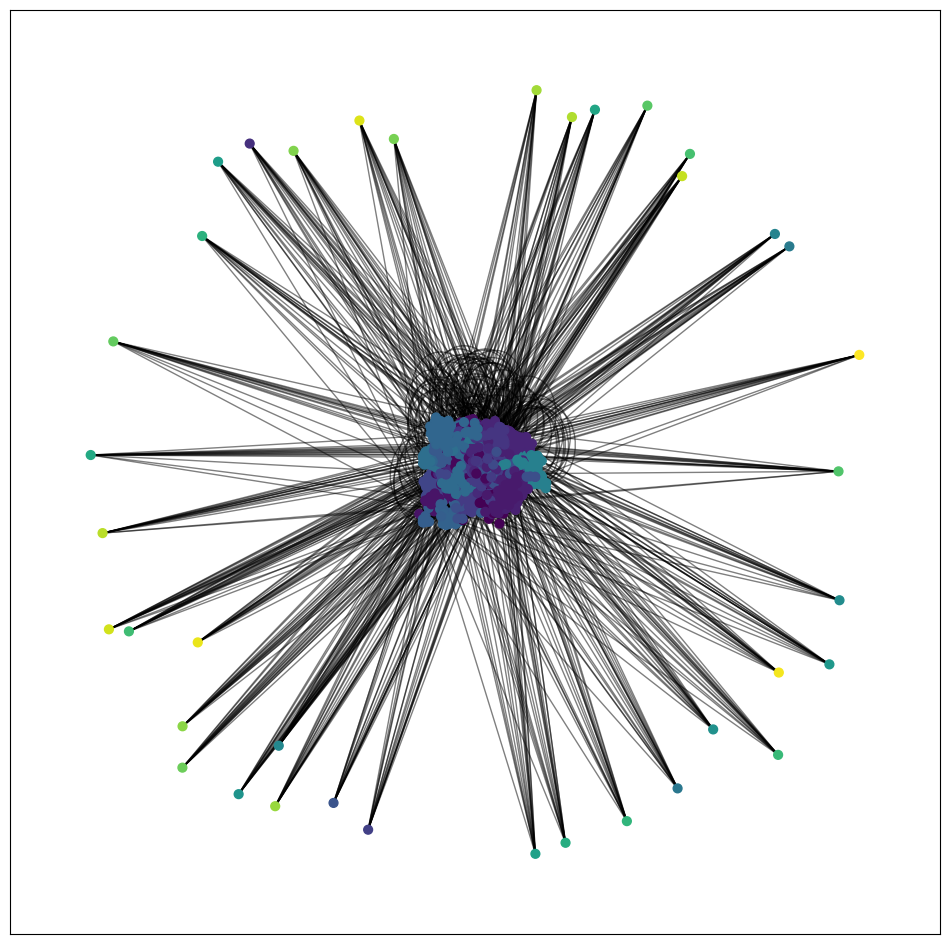

In [14]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# Create the graph
G = nx.Graph()

# Add edges with weights
for _, row in top_n_df.iterrows():
    G.add_edge(row['title1'], row['title2'], weight=row['cos_sim'])

# Compute the best partition
partition = community_louvain.best_partition(G, weight='weight')

# Compute modularity
modularity = community_louvain.modularity(partition, G)
print("Modularity: ", modularity)

# Visualize the graph with community coloring
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()


In [15]:
# Mapping titles to their clusters
clusters = [{"Title": title, "Cluster": cluster} for title, cluster in partition.items()]
clusters_df = pd.DataFrame(clusters)

# Display the DataFrame
print(clusters_df)


                                                  Title  Cluster
0                                          overwegingen        0
1                                overwegingen inleiding        0
2     appellant mei aanvraag ingediend subsidie gron...        1
3                                             appellant        1
4     verweerder stelt standpunt isde aanvraag terec...        1
...                                                 ...      ...
2273                opgeleverd werkelijke opbrengst x x       58
2274                                         schadepost        8
2275                                            vergoed       11
2276  betoog verzoeker inconsequente behandeling sch...       19
2277                    non destructief radio fotograaf       23

[2278 rows x 2 columns]


In [16]:
clusters_df.to_csv("cluster.csv")

In [17]:
final_df = extended_data.copy()
final_df['kmeans_cluster'] = results['category']

final_df


,Unnamed: 0,ecli,date,inhoudsindicatie,procesverloop,overwegingen,beslissing,sections,clean,cleaned_sections,lemmatized_sections,kmeans_cluster
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,Overwegingen,[overwegingen],[overwegingen],overwegingen,5
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.1 Appellant heeft op 10 mei 2020 een aanvraa...,"[appellant, heeft, op, mei, een, aanvraag, ing...","[appellant, mei, aanvraag, ingediend, subsidie...",appellant mei aanvraag ingediend subsidie gron...,1
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,4.5 van de Regeling. De minister van BZK heeft...,"[van, de, regeling, de, minister, van, bzk, he...","[regeling, minister, bzk, besluit, september, ...",regeling minister bzk besluit september appell...,1
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.2 In navolging van het e-mailbericht van 2 s...,"[in, navolging, van, het, e, mailbericht, van,...","[navolging, e, mailbericht, september, rvo, ap...",navolging e mailbericht september rvo appellan...,1
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,"1.3 Bij het primaire besluit, dat is gehandhaa...","[bij, het, primaire, besluit, dat, is, gehandh...","[primaire, besluit, gehandhaafd, bestreden, be...",primaire besluit gehandhaafd bestreden besluit...,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,"74.20.1, betekent niet dat verweerder de aanvr...","[betekent, niet, dat, verweerder, de, aanvraag...","[betekent, verweerder, aanvraag, appellant, al...",betekent verweerder aanvraag appellant alsnog ...,1
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,7. Anders dan appellant is het College van oo...,"[anders, dan, appellant, is, het, college, van...","[anders, appellant, college, oordeel, verweerd...",anders appellant college oordeel verweerder ge...,3
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,71.20.2 wel passend is bij de bedrijfsomschrij...,"[wel, passend, is, bij, de, bedrijfsomschrijvi...","[passend, bedrijfsomschrijving, maart, geregis...",passend bedrijfsomschrijving maart geregistree...,3
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,8. Het College volgt verweerder in het standp...,"[het, college, volgt, verweerder, in, het, sta...","[college, volgt, verweerder, standpunt, sprake...",college volgt verwee

In [18]:
final_df['graph_cluster'] = clusters_df['Cluster']
final_df

,Unnamed: 0,ecli,date,inhoudsindicatie,procesverloop,overwegingen,beslissing,sections,clean,cleaned_sections,lemmatized_sections,kmeans_cluster,graph_cluster
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,Overwegingen,[overwegingen],[overwegingen],overwegingen,5,0
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.1 Appellant heeft op 10 mei 2020 een aanvraa...,"[appellant, heeft, op, mei, een, aanvraag, ing...","[appellant, mei, aanvraag, ingediend, subsidie...",appellant mei aanvraag ingediend subsidie gron...,1,0
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,4.5 van de Regeling. De minister van BZK heeft...,"[van, de, regeling, de, minister, van, bzk, he...","[regeling, minister, bzk, besluit, september, ...",regeling minister bzk besluit september appell...,1,0
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,1.2 In navolging van het e-mailbericht van 2 s...,"[in, navolging, van, het, e, mailbericht, van,...","[navolging, e, mailbericht, september, rvo, ap...",navolging e mailbericht september rvo appellan...,1,0
0,0,ECLI:NL:CBB:2022:1,2022-01-11,"\n\nArtikel 2:3, eerste lid, van de Algemene w...",Procesverloop Bij besluit van 2 oktober 2020 (...,Overwegingen 1.1 Appellant heeft op 10 mei 202...,Beslissing Het College: - verklaart het beroep...,"1.3 Bij het primaire besluit, dat is gehandhaa...","[bij, het, primaire, besluit, dat, is, gehandh...","[primaire, besluit, gehandhaafd, bestreden, be...",primaire besluit gehandhaafd bestreden besluit...,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,"74.20.1, betekent niet dat verweerder de aanvr...","[betekent, niet, dat, verweerder, de, aanvraag...","[betekent, verweerder, aanvraag, appellant, al...",betekent verweerder aanvraag appellant alsnog ...,1,0
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,7. Anders dan appellant is het College van oo...,"[anders, dan, appellant, is, het, college, van...","[anders, appellant, college, oordeel, verweerd...",anders appellant college oordeel verweerder ge...,3,0
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,71.20.2 wel passend is bij de bedrijfsomschrij...,"[wel, passend, is, bij, de, bedrijfsomschrijvi...","[passend, bedrijfsomschrijving, maart, geregis...",passend bedrijfsomschrijving maart geregistree...,3,0
99,99,ECLI:NL:CBB:2022:21,2022-01-18,\nTOGS. Beroep ongegrond. Verweerder heeft zij...,Procesverloop Bij besluit van 3 juli 2020 (het...,Overwegingen Aanleiding van deze procedure 1. ...,Beslissing Het College verklaart het beroep on...,8. Het College volgt verweerder in het standp...,"[het, college, volgt, verweerder, in, het, sta...","[college, volgt, verweerder, standpun

In [19]:
final_df.to_csv("final_result.csv")